In [1]:
import os.path
import numpy as np
import matplotlib.pyplot as plt
import scipy
import refnx
from refnx.dataset import ReflectDataset, Data1D
from refnx.analysis import Transform, CurveFitter, Objective, Model, Parameter
from refnx.reflect import SLD, Slab, ReflectModel
from sepObjective import getObjective as gO
from dynesty import DynamicNestedSampler
from dynesty import plotting as dyplot
from CFitter import CFitter
import make_sim_data as msd
print('refnx: %s\nscipy: %s\nnumpy: %s' % (refnx.version.version,
                   scipy.version.version, np.version.version))


refnx: 0.1.9
scipy: 1.3.0
numpy: 1.16.4
refnx: 0.1.9
scipy: 1.3.0
numpy: 1.16.4


In [2]:
def aPlotter(res, interestingNo, spacesize, figI):
    print(figI)
    # no = -1000
    # slc = slice(no-1000,no)
    useAbleLow=0.1
    useAbleHigh=10.
    xall=np.linspace(0,spacesize,len(res["logz"]))
    print("len",len(res["logz"]), "space size", spacesize)
    useable=np.transpose(np.array([[x,y] for y,x in zip(res["logz"],xall) if np.exp(y)>useAbleLow and np.exp(y)<=useAbleHigh]))
    # print(len(res["logz"]),res["logz"][slc])#summary()
    interesting = np.transpose(np.array([[x,y] for y,x in zip(res["logz"],xall) if x>=float(interestingNo)]))#.reshape((2,-2))
    print("len 2", len(interesting[0]), len(interesting), interesting[0,:3])
    print("logz max: ",max(res["logz"]),",min: ",min(res["logz"]))
    print("z max: ",max(np.exp(res["logz"])),",min: ",min(np.exp(res["logz"])))
#     print(res["logz"][:5],interesting[1,:5],useable[1,:5])
    # print("interesting")
#     xall=np.linspace(0,spacesize,len(res["logz"]))
#     xusable=np.linspace(0,spacesize,len(useable))
    plt.figure(figI)
    figI+=1
    plt.plot(xall,res["logz"])
    plt.title("ln(evidence) log scaled vs -ln(X)")
    plt.yscale("log")
    plt.figure(figI)
    figI+=1
    plt.plot(interesting[0],interesting[1])
    plt.title(r"interesting values ln(evidence)  vs -ln(X) $\geq %d$" % interestingNo)
    if len(useable)>=2:
        plt.figure(figI)
        figI+=1
        plt.plot(useable[0],useable[1])
        plt.title(r"usful values ln(%.3f<evidence $\leq$ %.3f)  vs -ln(X)"%(useAbleLow,useAbleHigh))
    print(figI)
    return figI

In [3]:
figI = 0
# simple structure
thicks_true = [10,120,100,130,10]
bs_true = [0,5,4.5,5,10]
roughs_true = [0,0,0,0,0]
# bs = [5,4.5,5]
# thicks = [120,100,130]
# roughs = [0,0,0]
bs = bs_true
thicks = thicks_true
roughs = roughs_true
loss = 1.
no_layers = len(bs)
no_layers = len(bs_true)
# no_layers = 3
layers = []
names = []
#names = ['layer1','layer2']
for i in range(no_layers):
    names.append('layer'+str(i))
for i in range(no_layers):
        sld = SLD(bs[i],name=names[i])
        layers.append(sld(thicks[i],roughs[i]))
structure = layers[0]
for layer in layers[1:]:
    structure|=layer
print("done")

done


done


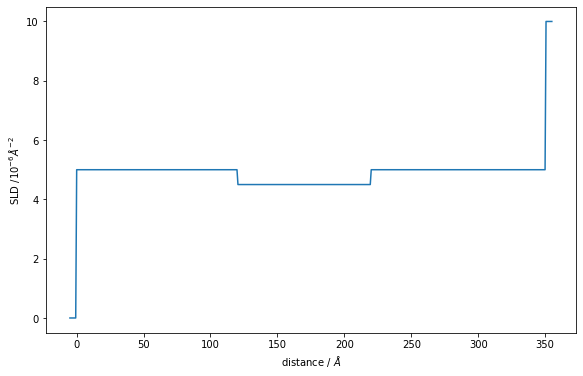

In [4]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [9.5, 6]
#notebook
plt.figure(figI)
figI+=1
plt.plot(*structure.sld_profile())
plt.ylabel('SLD /$10^{-6} \AA^{-2}$')
plt.xlabel('distance / $\AA$');
print("done")

In [5]:
resolution = 5.
model = ReflectModel(structure, bkg=3e-6, dq=resolution)

csv
cvs-collecting
out  [3.47819830e+02 8.77904741e+01 3.20810699e+03 9.49732939e-37
 1.65307010e-05] 
var:  [[1.76447440e+01 1.39762075e+02 1.90993913e+00 2.55098590e+04
  6.99628049e-05]
 [1.39762075e+02 1.10704093e+03 1.51284720e+01 2.01610925e+05
  5.54070662e-04]
 [1.90993913e+00 1.51284720e+01 2.06742813e-01 2.73481708e+03
  7.56735044e-06]
 [2.55098590e+04 2.01610925e+05 2.73481708e+03 2.55670288e+08
  1.48331018e-01]
 [6.99628049e-05 5.54070662e-04 7.56735044e-06 1.48331018e-01
  2.92147690e-10]]


<ErrorbarContainer object of 3 artists>

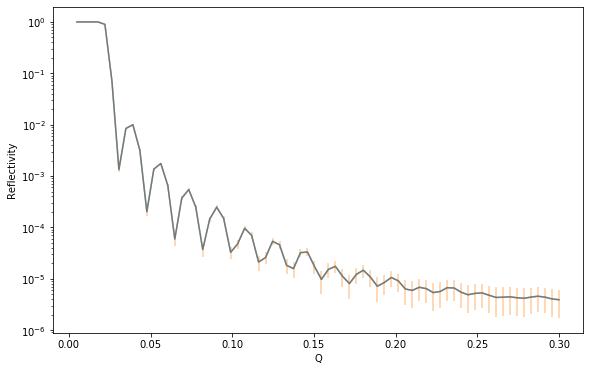

In [6]:
q = np.linspace(0.005, 0.3, 70)# was 1001 no 70
plt.figure(figI)
figI+=1
R = model(q, x_err=resolution)
plt.plot(q, R)
plt.xlabel('Q')
plt.ylabel('Reflectivity')
plt.yscale('log')
#Q, R(Q), sig_Q, sig_R =
import make_sim_data as msd
sim_dR = msd.main(sim_q=q,sim_R=R)*10
R = model(q, x_err=resolution)
plt.errorbar(q,R,sim_dR, alpha=0.4)

In [7]:
data = Data1D(data= (q,R,sim_dR))

In [8]:
# # from sepObjective import getObjective as gO
# objective = gO(data, 3)
# # from CFitter import CFitter
# # def ex
# fitter = CFitter(objective)
# # from dynesty import DynamicNestedSampler
# DNSampler = DynamicNestedSampler(fitter.logl, fitter.priorTransform, fitter.nDim())
# DNSampler.run_nested(dlogz_init=0.01)
# res = DNSampler.results # 07:18 mins


In [9]:
# res.summary()

summary() doesnt seem useable for dynamic sampling.\
MultiEllipsoidSamplerSamples conditioned on the union of multiple (possibly overlapping) ellipsoids used to bound the set of live points.

calculation is taking ln(z) = ln(evidence) and taking the exponent

In [10]:
# fig, ax = objective.plot()
# figI+=1
# plt.figure(figI)
# figI+=1
# plt.plot(*structure.sld_profile())
# plt.ylabel('SLD /$10^{-6} \AA^{-2}$')
# plt.xlabel('distance / $\AA$');

In [11]:
# span = [(0,5000),(0,1.5),(0,0.4),(10**0,10**1)]
# fig, axes = dyplot.runplot(res,span=span, color='black', mark_final_live=False,
#                            logplot=False)
# fig.tight_layout()

In [12]:
# figI = aPlotter(res, 19, 35, figI)

In [13]:
# fig, axes = dyplot.traceplot(res, truths=np.zeros(fitter.nDim()),
#                              show_titles=True, trace_cmap='plasma',
#                              quantiles=None,
#                            logplot=False)
# fig.tight_layout()

## 1 layered

In [14]:
objective = gO(data, 1) # was 06:09 now 0:36
fitter = CFitter(objective)
DNSampler = DynamicNestedSampler(fitter.logl, fitter.priorTransform, fitter.nDim())
DNSampler.run_nested(dlogz_init=0.05) # was 0.01
res1 = DNSampler.results

21713it [04:36, 78.66it/s, batch: 9 | bound: 66 | nc: 1 | ncall: 64560 | eff(%): 33.632 | loglstar: -1811.602 < -1805.361 < -1805.882 | logz: -1818.340 +/-  0.211 | stop:  0.955]      


was\
25968it [06:09, 70.27it/s, batch: 10 | bound: 81 | nc: 1 | ncall: 75806 | eff(%): 34.256 | loglstar: -44363.849 < -44357.543 < -44357.955 | logz: -44375.162 +/-  0.250 | stop:  0.975] 

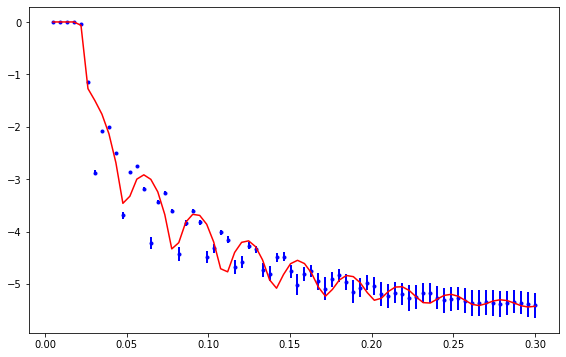

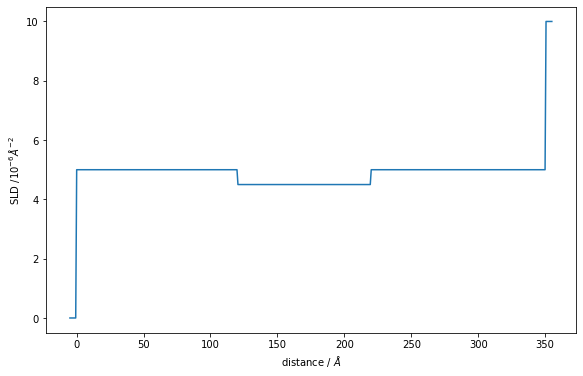

In [15]:
fig, ax = objective.plot()
figI+=1
plt.figure(figI)
figI+=1
plt.plot(*structure.sld_profile())
plt.ylabel('SLD /$10^{-6} \AA^{-2}$')
plt.xlabel('distance / $\AA$');

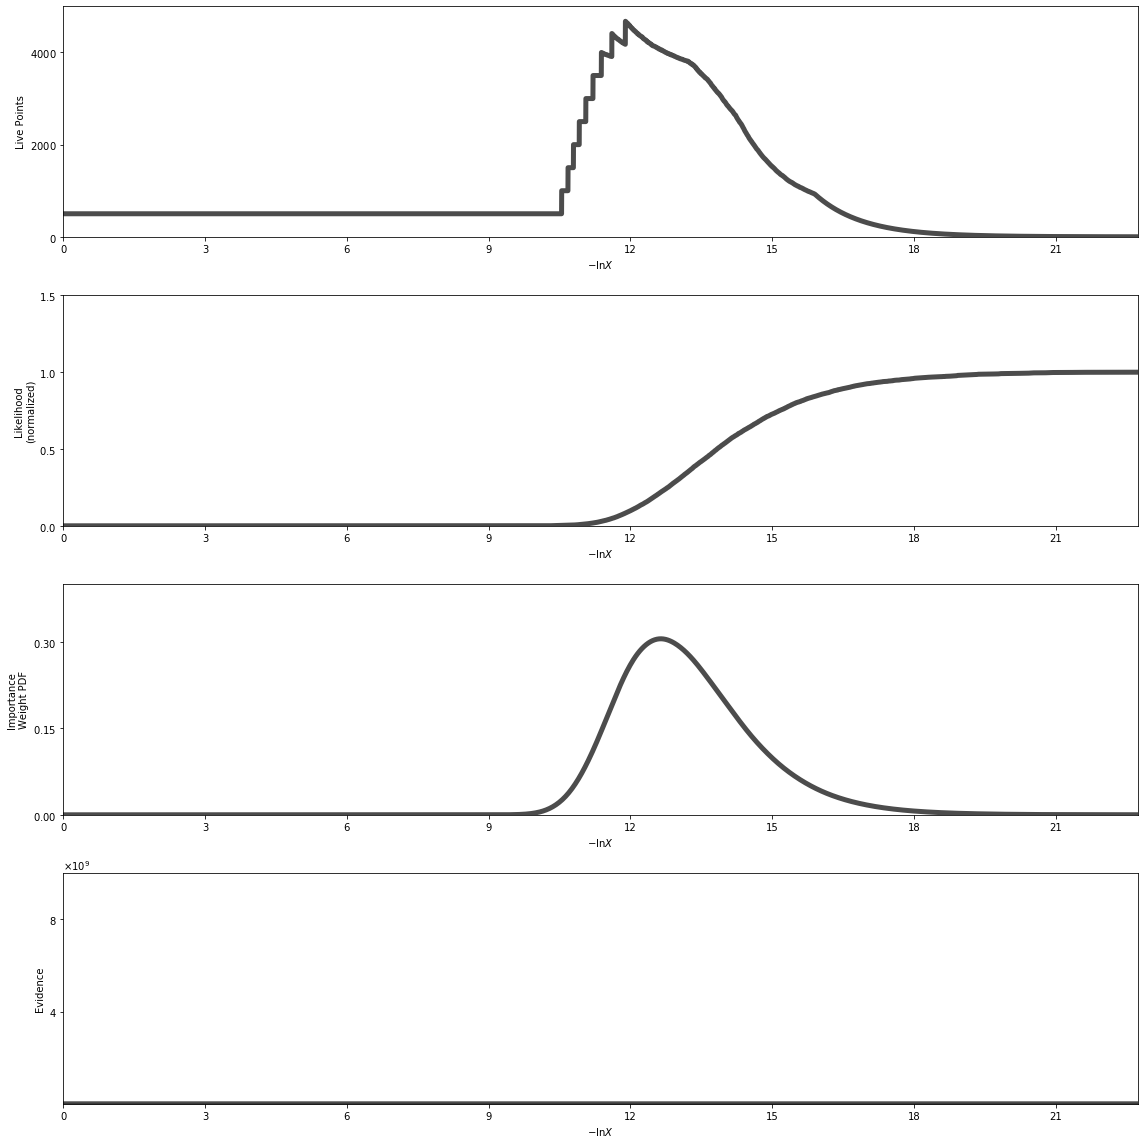

In [16]:
span = [(0,5000),(0,1.5),(0,0.4),(10**0,10**10)]
fig, axes = dyplot.runplot(res1,span=span, color='black', mark_final_live=False,
                           logplot=False)
fig.tight_layout()

4
len 21713 space size 29
len 2 12728 2 [12.00096721 12.00230287 12.00363854]
logz max:  -1818.3441558015368 ,min:  -29566.738995265416
z max:  0.0 ,min:  0.0
6


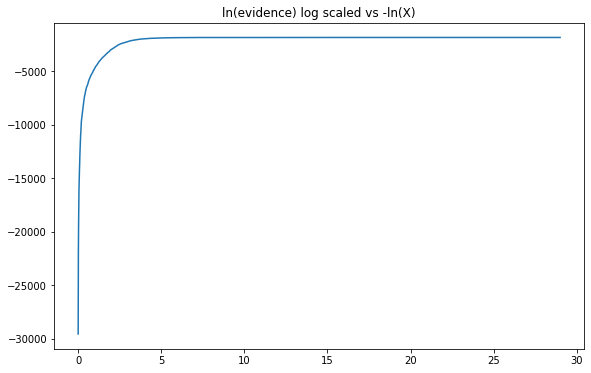

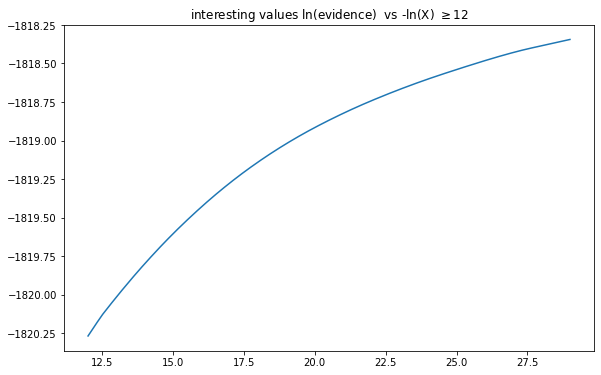

In [17]:
figI = aPlotter(res1, 12, 29, figI)

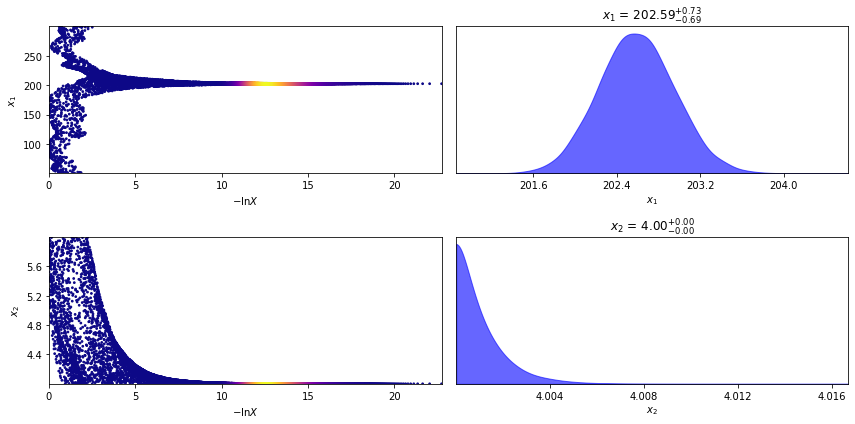

In [18]:
fig, axes = dyplot.traceplot(res1, truths=np.zeros(fitter.nDim()),
                             show_titles=True, trace_cmap='plasma',
                             quantiles=None)
fig.tight_layout()

## 2 layered

In [19]:
objective = gO(data, 2) # 05:20
fitter = CFitter(objective)
DNSampler = DynamicNestedSampler(fitter.logl, fitter.priorTransform, fitter.nDim())
DNSampler.run_nested(dlogz_init=0.05)
res2 = DNSampler.results

24152it [05:21, 75.10it/s, batch: 9 | bound: 79 | nc: 2 | ncall: 76847 | eff(%): 31.429 | loglstar: 78.380 < 85.912 < 85.243 | logz: 72.686 +/-  0.202 | stop:  0.836]                


was\
24744it [05:20, 77.20it/s, batch: 8 | bound: 74 | nc: 1 | ncall: 70332 | eff(%): 35.182 | loglstar: 1241.354 < 1247.885 < 1247.372 | logz: 1228.828 +/-  0.255 | stop:  0.951]

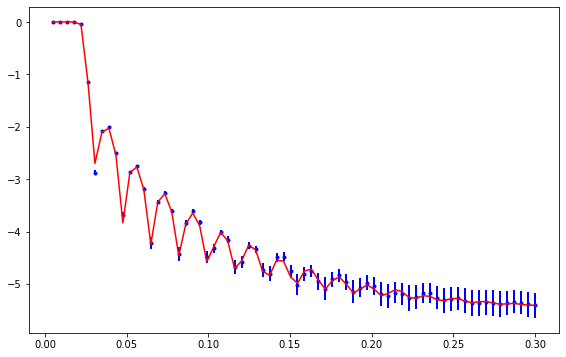

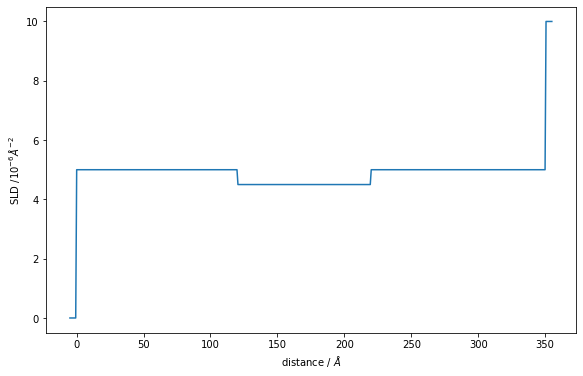

In [20]:
fig, ax = objective.plot()
figI+=1
plt.figure(figI)
figI+=1
plt.plot(*structure.sld_profile())
plt.ylabel('SLD /$10^{-6} \AA^{-2}$')
plt.xlabel('distance / $\AA$');

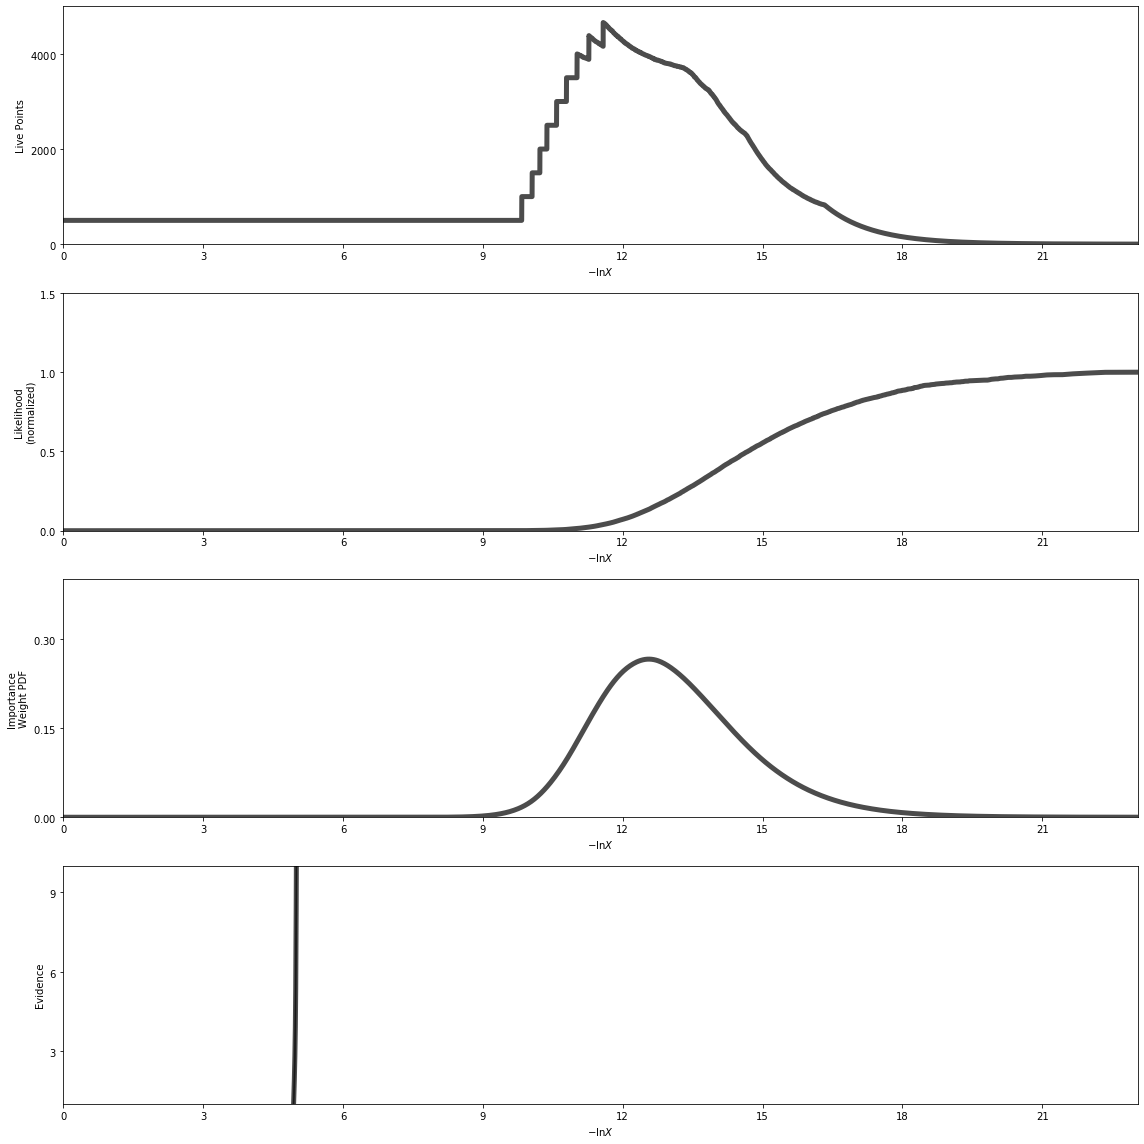

In [21]:
span = [(0,5000),(0,1.5),(0,0.4),(10**0,10**1)]
fig, axes = dyplot.runplot(res2,span=span, color='black', mark_final_live=False,
                           logplot=False)
fig.tight_layout()

8
len 24152 space size 30
len 2 12881 2 [14.0006625  14.00190468 14.00314687]
logz max:  72.70970403187393 ,min:  -20652.690545758724
z max:  3.7794033341303583e+31 ,min:  0.0
11


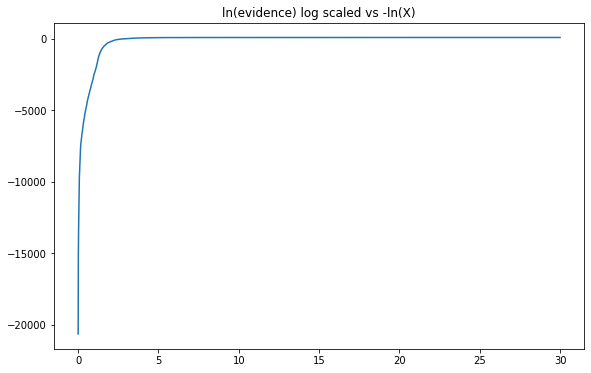

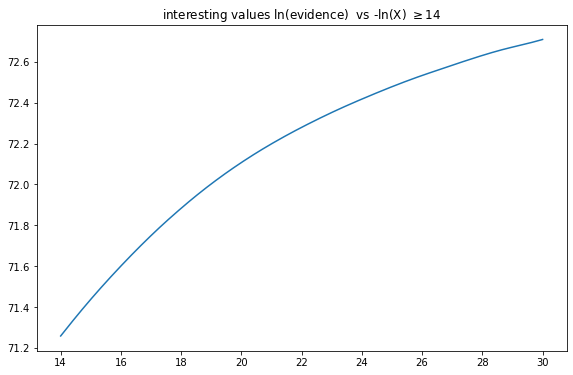

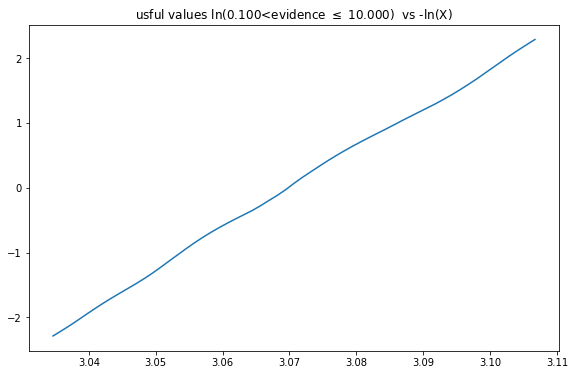

In [22]:
figI = aPlotter(res2, 14, 30, figI)

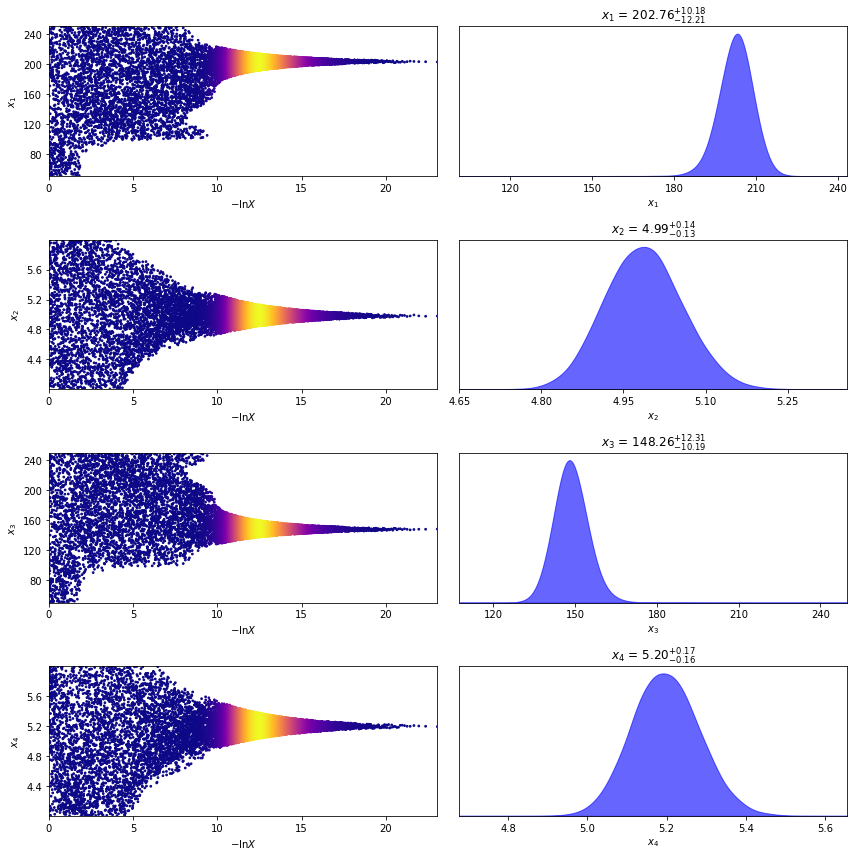

In [23]:
fig, axes = dyplot.traceplot(res2, truths=np.zeros(fitter.nDim()),
                             show_titles=True, trace_cmap='plasma',
                             quantiles=None)
fig.tight_layout()

## 3 layered

In [24]:
objective = gO(data, 3)
fitter = CFitter(objective)
DNSampler = DynamicNestedSampler(fitter.logl, fitter.priorTransform, fitter.nDim())
DNSampler.run_nested(dlogz_init=0.05)
res3 = DNSampler.results 

28609it [09:55, 48.06it/s, batch: 8 | bound: 189 | nc: 17 | ncall: 192219 | eff(%): 14.884 | loglstar: 100.123 < 108.366 < 108.319 | logz: 91.440 +/-  0.226 | stop:  0.901]          


was\
29853it [08:20, 59.62it/s, batch: 8 | bound: 162 | nc: 5 | ncall: 145942 | eff(%): 20.455 | loglstar: 1542.518 < 1550.310 < 1548.441 | logz: 1525.116 +/-  0.291 | stop:  0.868]

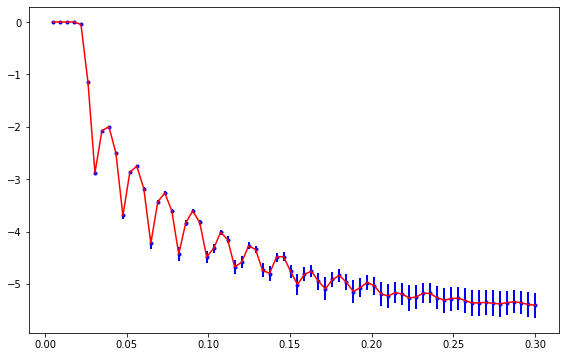

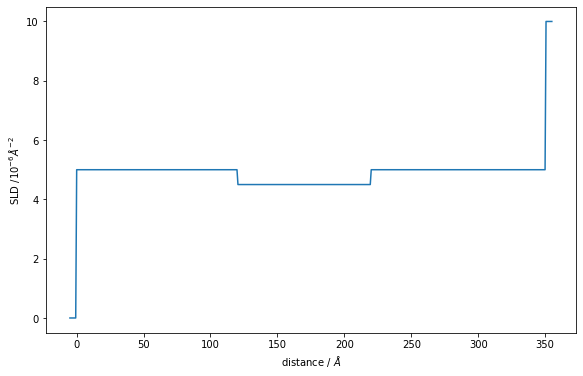

In [25]:
fig, ax = objective.plot()
figI+=1
plt.figure(figI)
figI+=1
plt.plot(*structure.sld_profile())
plt.ylabel('SLD /$10^{-6} \AA^{-2}$')
plt.xlabel('distance / $\AA$');

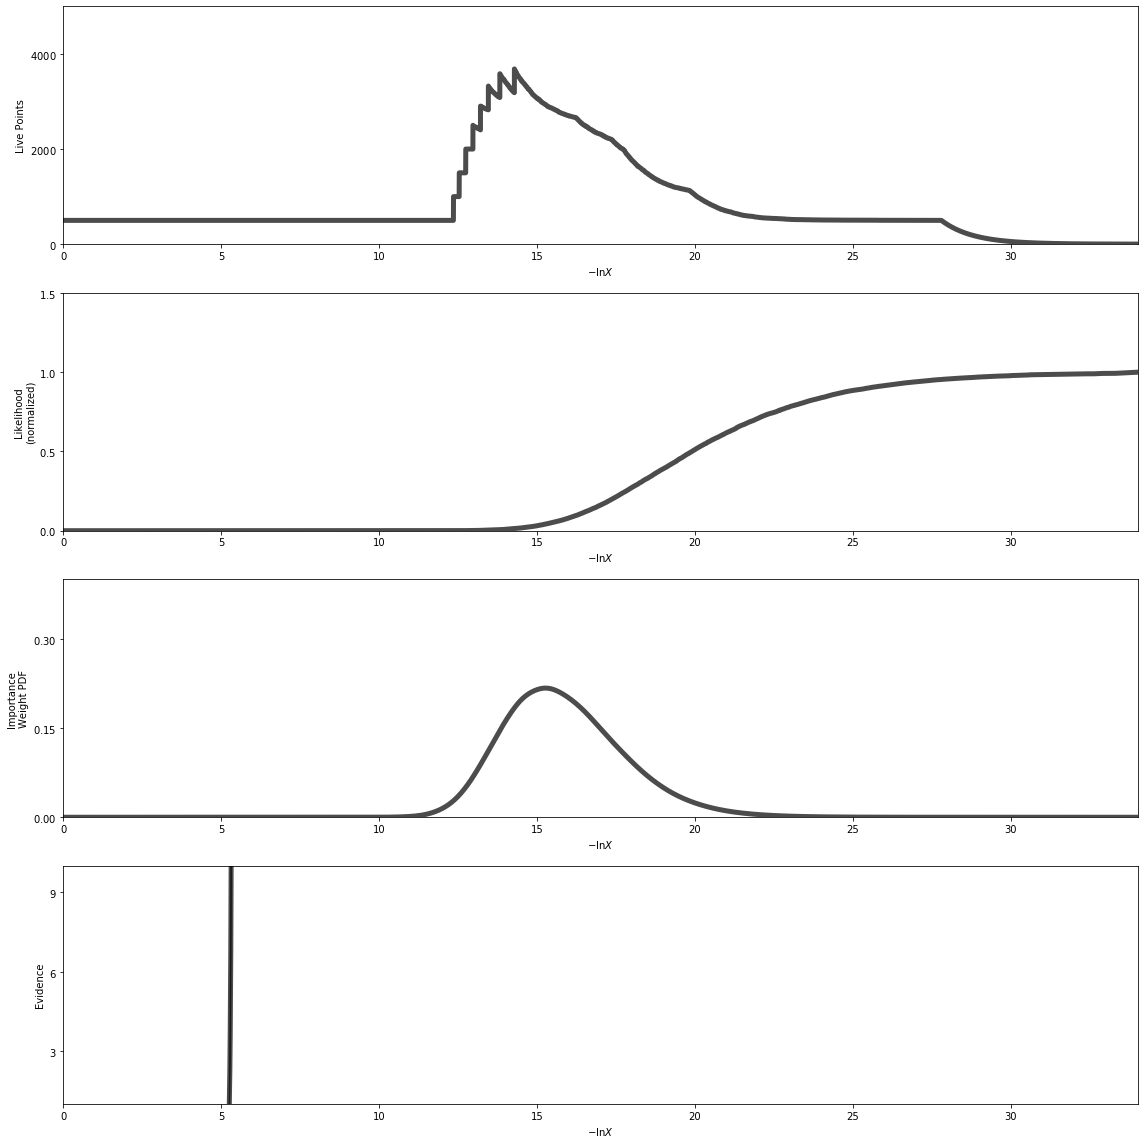

In [26]:
span = [(0,5000),(0,1.5),(0,0.4),(10**0,10**1)]
fig, axes = dyplot.runplot(res3,span=span, color='black', mark_final_live=False,
                           logplot=False)
fig.tight_layout()

13
len 28609 space size 35
len 2 13078 2 [19.00115352 19.00237696 19.00360039]
logz max:  91.43704972518914 ,min:  -25685.59229081221
z max:  5.1357767533771516e+39 ,min:  0.0
16


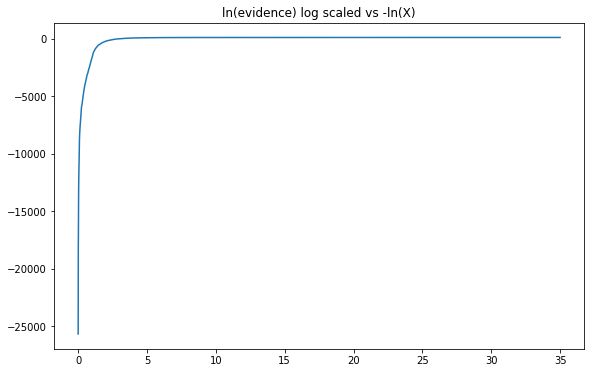

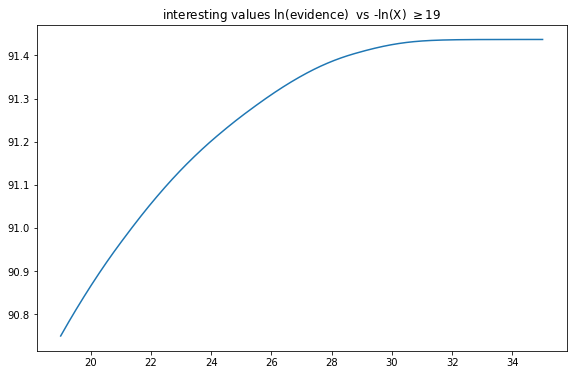

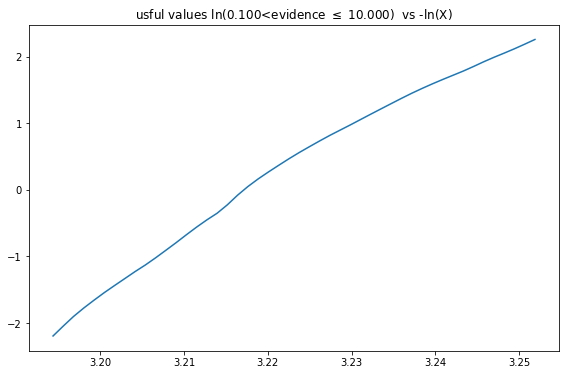

In [27]:
figI = aPlotter(res3, 19, 35, figI)

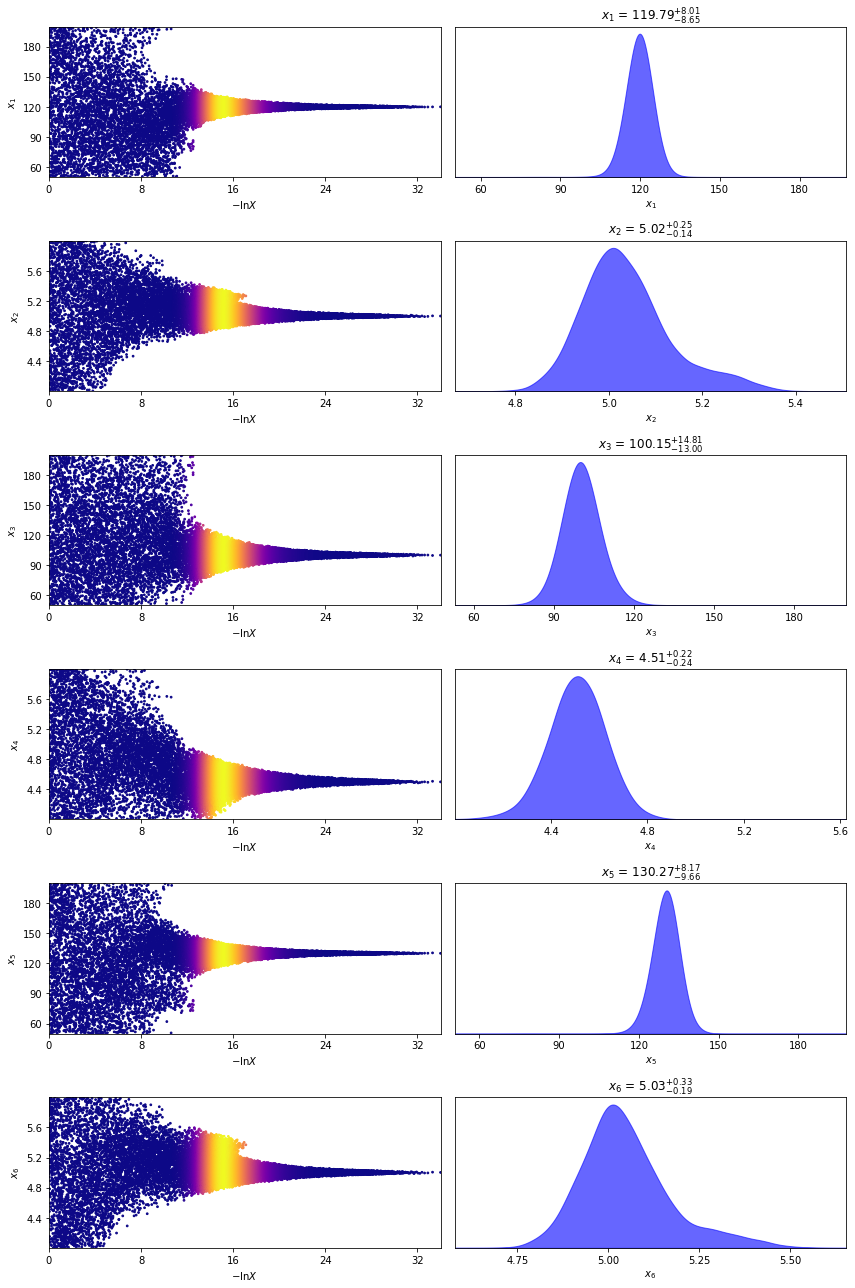

In [28]:
fig, axes = dyplot.traceplot(res3, truths=np.zeros(fitter.nDim()),
                             show_titles=True, trace_cmap='plasma',
                             quantiles=None)
fig.tight_layout()

## 4 layered

In [29]:
objective = gO(data, 4)
fitter = CFitter(objective)
DNSampler = DynamicNestedSampler(fitter.logl, fitter.priorTransform, fitter.nDim()) 
DNSampler.run_nested(dlogz_init=0.05)
res4 = DNSampler.results

23525it [3:44:24,  1.75it/s, batch: 7 | bound: 6692 | nc: 2 | ncall: 5965849 | eff(%):  0.394 | loglstar: 99.513 < 108.013 < 105.725 | logz: 89.845 +/-  0.233 | stop:  0.930]            


was\
28647it [3:31:10,  2.26it/s, batch: 7 | bound: 4789 | nc: 46 | ncall: 4527187 | eff(%):  0.633 | loglstar: 1542.404 < 1550.302 < 1547.665 | logz: 1522.275 +/-  0.307 | stop:  0.953]  

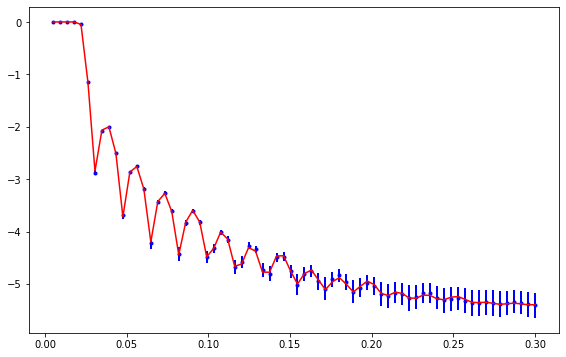

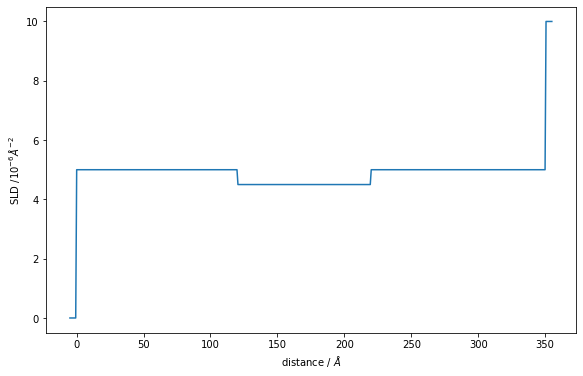

In [30]:
fig, ax = objective.plot()
figI+=1
plt.figure(figI)
figI+=1
plt.plot(*structure.sld_profile())
plt.ylabel('SLD /$10^{-6} \AA^{-2}$')
plt.xlabel('distance / $\AA$');

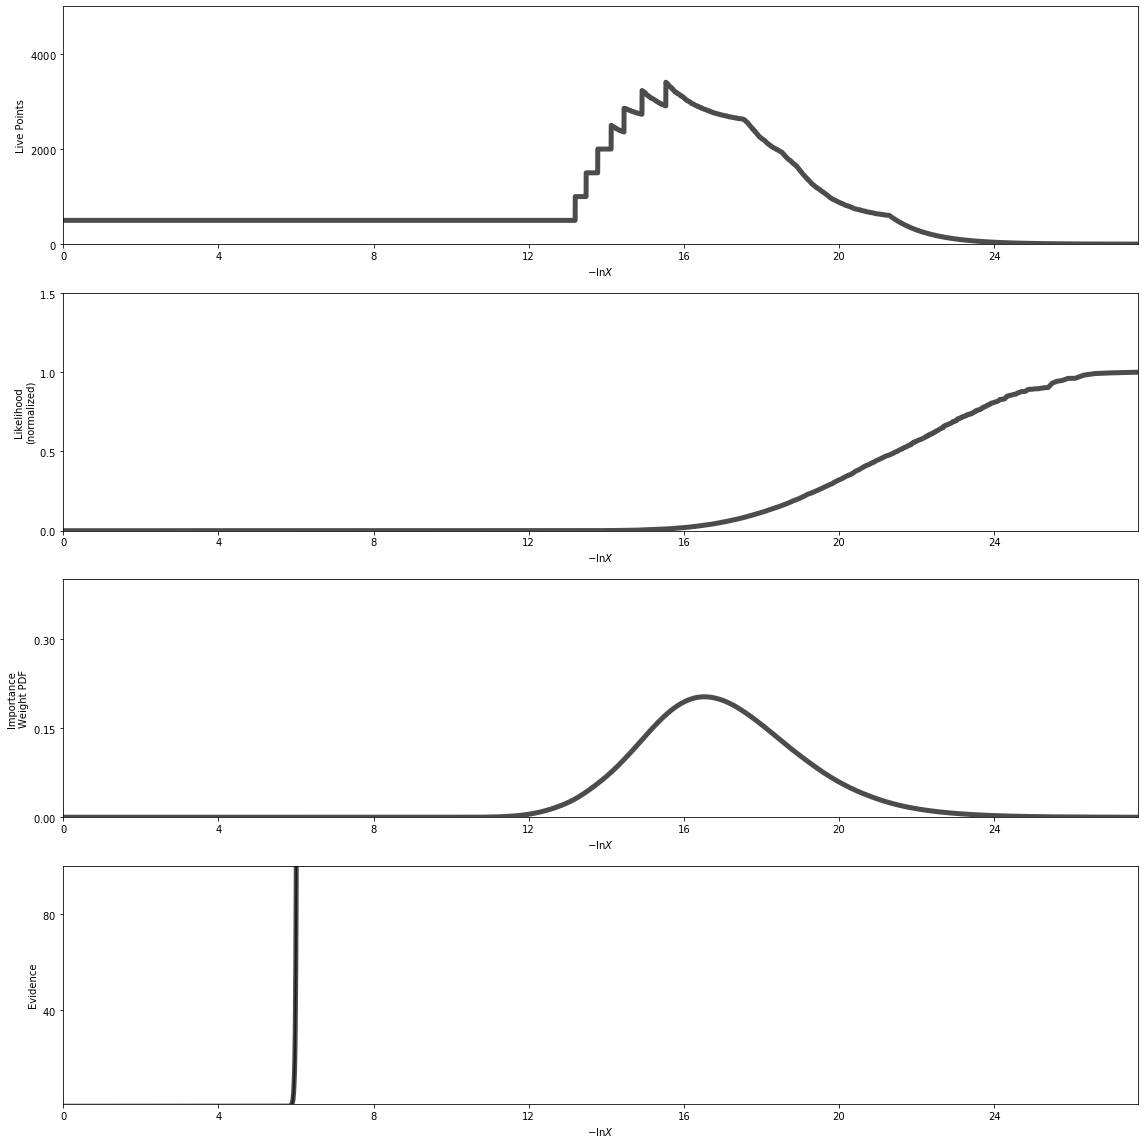

In [31]:
span = [(0,5000),(0,1.5),(0,0.4),(10**0,10**2)]
fig, axes = dyplot.runplot(res4,span=span, color='black', mark_final_live=False,
                           logplot=False)
fig.tight_layout()

18
len 23525 space size 40
len 2 11763 2 [20.         20.00170039 20.00340078]
logz max:  89.84764701774884 ,min:  -23590.84886801486
z max:  1.0479421573224804e+39 ,min:  0.0
21


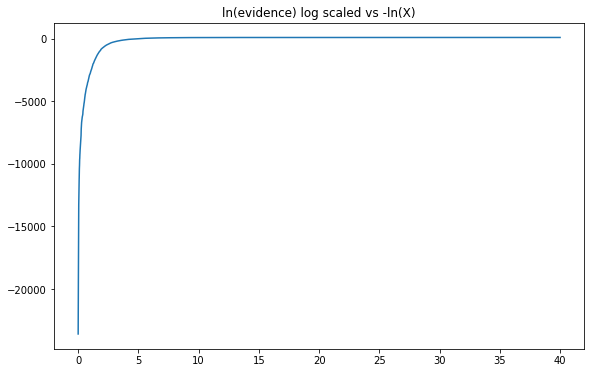

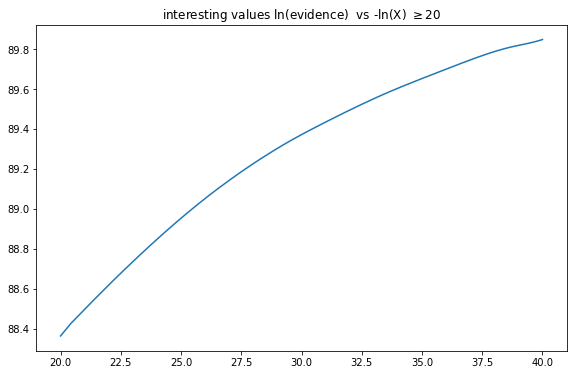

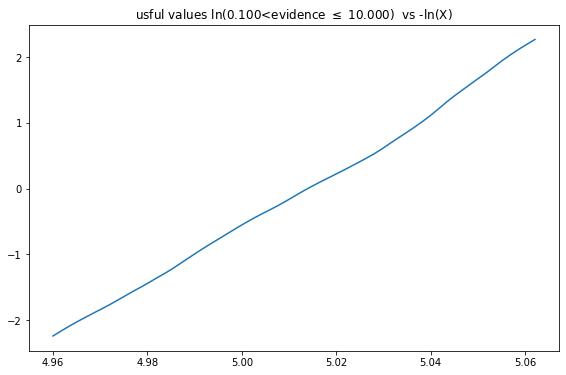

In [32]:
figI = aPlotter(res4, 20, 40, figI)

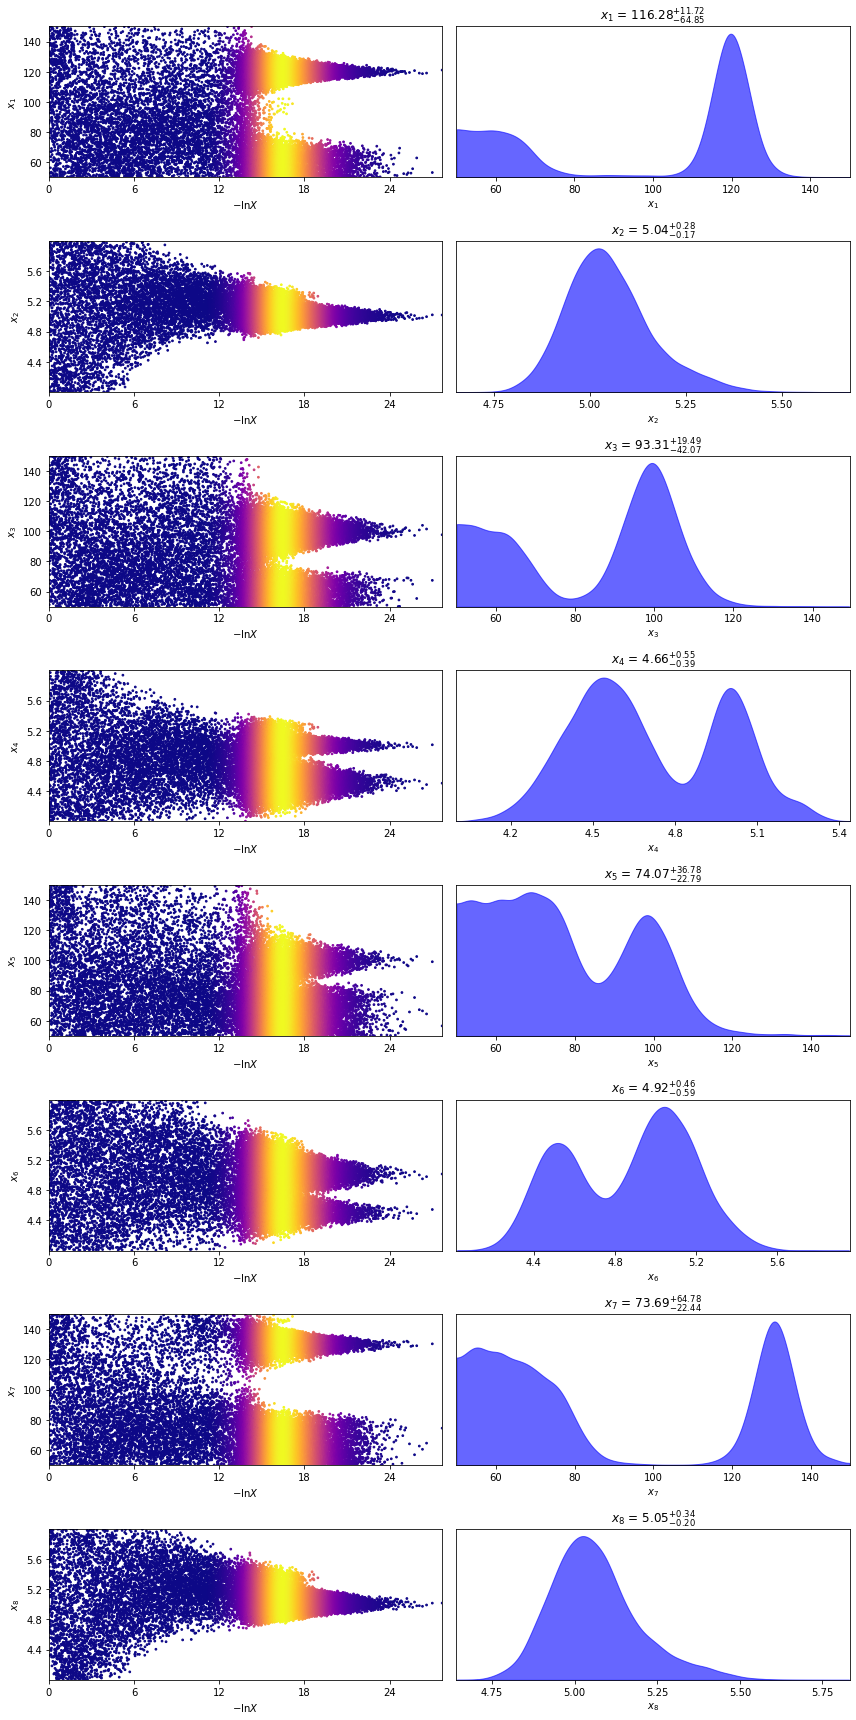

In [33]:
fig, axes = dyplot.traceplot(res4, truths=np.zeros(fitter.nDim()),
                             show_titles=True, trace_cmap='plasma',
                             quantiles=None)
fig.tight_layout()